### Importing key libraries

In [1]:
import os, json, yaml, warnings, random
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn import metrics
import optuna

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Uncommon packages
# !pip install -q split-folders optuna-integration

### TF configuration

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

### Non-optimized hyperparameters

In [4]:
IMG_SIZE = 224
NUM_EPOCHS = 100 # doesn't matter much because of EarlyStopping
# EarlyStopping
PATIENCE = 5 # no. of epochs with no improvement after which training will be stopped
# ReduceLROnPlateau
LR_PATIENCE = 5 # no. of epochs with no improvement after which learning rate will be reduced
LR_FACTOR = 0.1 # factor by which the learning rate will be reduced
MIN_LR = 1e-6 # lower bound on the learning rate
# Optuna
OPTUNA_TRIALS = 100

### Dataset splitting (one-time)

In [5]:
output_dir = r'splitted_data' # Intentionally declared in separate cell

In [6]:
# import splitfolders

# dataset_dir = r'dataset'

# # Make output dir if doesn't exist, else skip
# os.makedirs(output_dir, exist_ok=True)

# splitfolders.ratio(dataset_dir, output=output_dir, seed=1337, ratio=(0.75, 0.15, 0.1))
# print(f"Dataset successfully splitted into: {os.listdir(output_dir)}")

### Dataset config

In [7]:
def helper_ds(partition, shuffle_status=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(output_dir, partition),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        label_mode='binary',
        shuffle=shuffle_status
    )

train_ds = helper_ds('train')
val_ds = helper_ds('val')
test_ds = helper_ds('test', False)


# Rescale layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Data augmentation for 'train' set
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.15),
        ])

AUTOTUNE = tf.data.AUTOTUNE

# Augmentation and rescaling for 'train' set
train_rsc = train_ds.map(lambda x, y: (rescale_layer(data_augmentation(x), training=True), y), num_parallel_calls=AUTOTUNE)
train_rsc = train_rsc.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Only rescaling for 'test' and 'val' set
val_rsc = val_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_rsc = test_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

Found 31344 files belonging to 2 classes.
Found 6268 files belonging to 2 classes.
Found 4181 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Saving the class names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Sanity check
print(f"Class names successfully saved.") if os.path.exists('class_names.json') else print(f"Failed to save the file.")

Class names: ['Drowsy', 'Non Drowsy']
Class names successfully saved.


### Data visualization

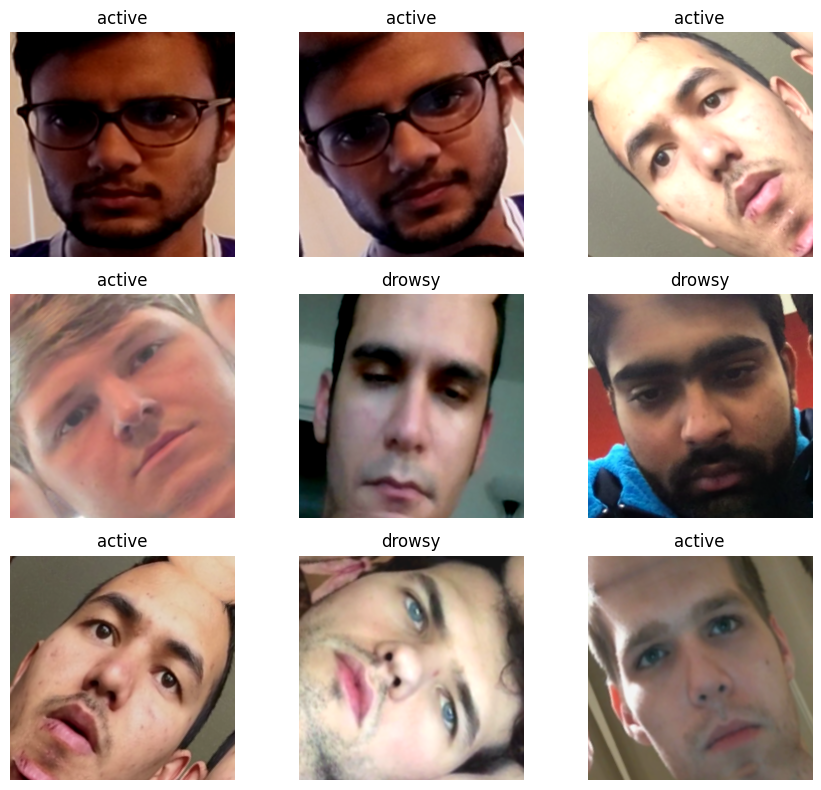

In [9]:
plt.figure(figsize=(10, 8))
for images, labels in train_rsc.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        state = "active" if int(labels[i]) else "drowsy"
        plt.title(state)
        plt.axis("off")
        plt.tight_layout()

### Stacking models

In [10]:
def stacked_model(input_shape=[IMG_SIZE, IMG_SIZE, 3], LEARNING_RATE=0.0001, DROPOUT_RATE=0.2):

    d_net = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    e_net = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)
    m_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the models
    d_net.trainable=False; e_net.trainable=False; m_net.trainable=False

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Averaging the outputs from each model
    d_net_gap = tf.keras.layers.GlobalAveragePooling2D()(d_net(inputs))
    e_net_gap = tf.keras.layers.GlobalAveragePooling2D()(e_net(inputs))
    m_net_gap = tf.keras.layers.GlobalAveragePooling2D()(m_net(inputs))

    # Combine outputs
    combined_outputs = tf.keras.layers.concatenate([d_net_gap, e_net_gap, m_net_gap])

    # Custom layers
    stacked_1 = tf.keras.layers.Dense(1024, activation='relu')(combined_outputs)
    stacked_1 = tf.keras.layers.BatchNormalization()(stacked_1)
    stacked_1 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_1)

    stacked_2 = tf.keras.layers.Dense(512, activation='relu')(stacked_1)
    stacked_2 = tf.keras.layers.BatchNormalization()(stacked_2)
    stacked_2 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_2)

    stacked_3 = tf.keras.layers.Dense(256, activation='relu')(stacked_2)
    stacked_3 = tf.keras.layers.BatchNormalization()(stacked_3)
    stacked_3 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_3)

    out = tf.keras.layers.Dense(1, activation='sigmoid')(stacked_3)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

### Defining callbacks

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints/best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Custom training curve callback
from IPython.display import clear_output

train_losses=[]; val_losses=[]; precision_scores=[]; recall_scores=[]

class TrainingCurveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])
        precision_scores.append(logs['precision'])
        recall_scores.append(logs['recall'])

        clear_output(wait=True) # clear output before plotting

        fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure; will contain loss/accuracy curves
        fig.suptitle('Training Curves')

        # loss curve (ax1 - left y axis)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(left=0)
        ax1.set_ylabel('Loss function')

        # determine left y axis range from min/max loss values
        y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
        y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0
        y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1 # find highest loss value across both curves, add some padding to the top of the plot
        ax1.set_ylim(y_ax1_min, y_ax1_max) # set y axis limits

        # Best epoch (smallest loss)
        best_epoch = int(np.argmin(val_losses))
        best_loss = val_losses[best_epoch]

        # add veritcal line for best epoch
        ax1.vlines(best_epoch, ymin=0, ymax=y_ax1_max, linestyles='dashed', colors='black',
                   label=f'best epoch={best_epoch}\nval loss={best_loss:.3f}')
        ax1.legend(loc='upper left')

        # create right y axis for precision/recall curves
        ax2 = ax1.twinx()

        # Plot precision/recall (right y-axis)
        ax2.plot(precision_scores, label=f'Precision\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
        ax2.plot(recall_scores, label=f'Recall\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
        ax2.set_ylabel('Precision / Recall')
        ax2.set_ylim(0, 1)
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

### Model summary (optional)

In [12]:
# ensemble_model = stacked_model()
# ensemble_model.summary()

### Running Optuna (skippable)

In [13]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'LEARNING_RATE': trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-2),
        'DROPOUT_RATE': trial.suggest_float('DROPOUT_RATE', 0.1, 0.5, step=0.1),
    }
    ensemble_model = stacked_model(LEARNING_RATE=params['LEARNING_RATE'], DROPOUT_RATE=params['DROPOUT_RATE'])

    optuna_pruner = optuna.integration.TFKerasPruningCallback(trial, monitor='val_loss')
    history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS, callbacks=[early_stopping, reduce_lr, optuna_pruner])
    return min(history.history['val_loss'])
    
study = optuna.create_study(direction='minimize') # minimize validation loss
study.optimize(objective, n_trials=OPTUNA_TRIALS)

[I 2025-07-11 14:33:38,153] A new study created in memory with name: no-name-5733bf25-9dbf-46ca-8098-1ad9141fa7d3


Epoch 1/100
980/980 [==============================] - 420s 409ms/step - loss: 0.1921 - accuracy: 0.9232 - precision: 0.9094 - recall: 0.9274 - val_loss: 0.0555 - val_accuracy: 0.9871 - val_precision: 0.9826 - val_recall: 0.9897 - lr: 2.6082e-05
Epoch 2/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0396 - accuracy: 0.9899 - precision: 0.9876 - recall: 0.9906 - val_loss: 0.0229 - val_accuracy: 0.9941 - val_precision: 0.9908 - val_recall: 0.9966 - lr: 2.6082e-05
Epoch 3/100
980/980 [==============================] - 392s 400ms/step - loss: 0.0179 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9960 - val_loss: 0.0234 - val_accuracy: 0.9944 - val_precision: 0.9888 - val_recall: 0.9993 - lr: 2.6082e-05
Epoch 4/100
980/980 [==============================] - 392s 400ms/step - loss: 0.0111 - accuracy: 0.9978 - precision: 0.9973 - recall: 0.9979 - val_loss: 0.0190 - val_accuracy: 0.9939 - val_precision: 0.9925 - val_recall: 0.9945 - lr: 2.6082e-05
Epoch 5/100
980/

[I 2025-07-11 16:57:53,449] Trial 0 finished with value: 0.003105121199041605 and parameters: {'LEARNING_RATE': 2.6081998983632334e-05, 'DROPOUT_RATE': 0.1}. Best is trial 0 with value: 0.003105121199041605.


Epoch 1/100
980/980 [==============================] - 409s 404ms/step - loss: 0.1450 - accuracy: 0.9440 - precision: 0.9354 - recall: 0.9449 - val_loss: 0.0352 - val_accuracy: 0.9947 - val_precision: 0.9932 - val_recall: 0.9955 - lr: 4.1857e-05
Epoch 2/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0277 - accuracy: 0.9925 - precision: 0.9916 - recall: 0.9922 - val_loss: 0.0230 - val_accuracy: 0.9938 - val_precision: 0.9997 - val_recall: 0.9870 - lr: 4.1857e-05
Epoch 3/100
980/980 [==============================] - 392s 400ms/step - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9965 - recall: 0.9975 - val_loss: 0.0150 - val_accuracy: 0.9955 - val_precision: 0.9915 - val_recall: 0.9990 - lr: 4.1857e-05
Epoch 4/100
980/980 [==============================] - 392s 400ms/step - loss: 0.0091 - accuracy: 0.9982 - precision: 0.9981 - recall: 0.9981 - val_loss: 0.0210 - val_accuracy: 0.9935 - val_precision: 0.9942 - val_recall: 0.9918 - lr: 4.1857e-05
Epoch 5/100
980/

[I 2025-07-11 19:41:41,229] Trial 1 finished with value: 0.002629093360155821 and parameters: {'LEARNING_RATE': 4.1856856209674816e-05, 'DROPOUT_RATE': 0.1}. Best is trial 1 with value: 0.002629093360155821.


Epoch 1/100
980/980 [==============================] - 411s 406ms/step - loss: 0.1441 - accuracy: 0.9433 - precision: 0.9353 - recall: 0.9434 - val_loss: 0.0412 - val_accuracy: 0.9880 - val_precision: 0.9931 - val_recall: 0.9811 - lr: 8.5771e-04
Epoch 2/100
980/980 [==============================] - 394s 403ms/step - loss: 0.0473 - accuracy: 0.9831 - precision: 0.9819 - recall: 0.9818 - val_loss: 0.0128 - val_accuracy: 0.9970 - val_precision: 0.9997 - val_recall: 0.9938 - lr: 8.5771e-04
Epoch 3/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0368 - accuracy: 0.9874 - precision: 0.9861 - recall: 0.9868 - val_loss: 0.0334 - val_accuracy: 0.9869 - val_precision: 0.9761 - val_recall: 0.9962 - lr: 8.5771e-04
Epoch 4/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0250 - accuracy: 0.9916 - precision: 0.9907 - recall: 0.9912 - val_loss: 0.0243 - val_accuracy: 0.9919 - val_precision: 0.9972 - val_recall: 0.9853 - lr: 8.5771e-04
Epoch 5/100
980/

[I 2025-07-11 23:12:34,113] Trial 2 finished with value: 0.001360870897769928 and parameters: {'LEARNING_RATE': 0.000857705911306056, 'DROPOUT_RATE': 0.4}. Best is trial 2 with value: 0.001360870897769928.


Epoch 1/100
980/980 [==============================] - 411s 407ms/step - loss: 0.3517 - accuracy: 0.8404 - precision: 0.8216 - recall: 0.8392 - val_loss: 0.1315 - val_accuracy: 0.9590 - val_precision: 0.9900 - val_recall: 0.9211 - lr: 2.7582e-05
Epoch 2/100
980/980 [==============================] - 396s 404ms/step - loss: 0.1110 - accuracy: 0.9601 - precision: 0.9563 - recall: 0.9581 - val_loss: 0.0413 - val_accuracy: 0.9920 - val_precision: 0.9918 - val_recall: 0.9911 - lr: 2.7582e-05
Epoch 3/100
980/980 [==============================] - 395s 404ms/step - loss: 0.0591 - accuracy: 0.9803 - precision: 0.9801 - recall: 0.9776 - val_loss: 0.0213 - val_accuracy: 0.9951 - val_precision: 0.9928 - val_recall: 0.9966 - lr: 2.7582e-05
Epoch 4/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0390 - accuracy: 0.9870 - precision: 0.9859 - recall: 0.9861 - val_loss: 0.0166 - val_accuracy: 0.9957 - val_precision: 0.9949 - val_recall: 0.9959 - lr: 2.7582e-05
Epoch 5/100
980/

[I 2025-07-12 01:38:06,302] Trial 3 finished with value: 0.004537711385637522 and parameters: {'LEARNING_RATE': 2.7582259141486005e-05, 'DROPOUT_RATE': 0.30000000000000004}. Best is trial 2 with value: 0.001360870897769928.


Epoch 1/100
980/980 [==============================] - 412s 407ms/step - loss: 0.1832 - accuracy: 0.9263 - precision: 0.9202 - recall: 0.9215 - val_loss: 0.3016 - val_accuracy: 0.8805 - val_precision: 0.7961 - val_recall: 0.9990 - lr: 0.0011
Epoch 2/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0621 - accuracy: 0.9788 - precision: 0.9779 - recall: 0.9765 - val_loss: 0.0306 - val_accuracy: 0.9899 - val_precision: 0.9857 - val_recall: 0.9928 - lr: 0.0011
Epoch 3/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0505 - accuracy: 0.9818 - precision: 0.9800 - recall: 0.9809 - val_loss: 0.0411 - val_accuracy: 0.9871 - val_precision: 0.9975 - val_recall: 0.9746 - lr: 0.0011
Epoch 4/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0387 - accuracy: 0.9870 - precision: 0.9865 - recall: 0.9857 - val_loss: 0.0235 - val_accuracy: 0.9911 - val_precision: 0.9931 - val_recall: 0.9877 - lr: 0.0011
Epoch 5/100
980/980 [===========

[I 2025-07-12 04:30:02,402] Trial 4 finished with value: 0.001137841958552599 and parameters: {'LEARNING_RATE': 0.0010756662967040516, 'DROPOUT_RATE': 0.5}. Best is trial 4 with value: 0.001137841958552599.


Epoch 1/100
980/980 [==============================] - 410s 407ms/step - loss: 0.1052 - accuracy: 0.9607 - precision: 0.9547 - recall: 0.9612 - val_loss: 0.0194 - val_accuracy: 0.9973 - val_precision: 0.9962 - val_recall: 0.9979 - lr: 8.2491e-05
Epoch 2/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0225 - accuracy: 0.9935 - precision: 0.9931 - recall: 0.9929 - val_loss: 0.0338 - val_accuracy: 0.9895 - val_precision: 0.9792 - val_recall: 0.9986 - lr: 8.2491e-05
Epoch 3/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0119 - accuracy: 0.9968 - precision: 0.9967 - recall: 0.9964 - val_loss: 0.0164 - val_accuracy: 0.9938 - val_precision: 0.9908 - val_recall: 0.9959 - lr: 8.2491e-05
Epoch 4/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0119 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9959 - val_loss: 0.0379 - val_accuracy: 0.9840 - val_precision: 0.9675 - val_recall: 0.9993 - lr: 8.2491e-05
Epoch 5/100
980/

[I 2025-07-12 05:29:47,918] Trial 5 pruned. Trial was pruned at epoch 8.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9543 - precision: 0.9443 - recall: 0.9584

[I 2025-07-12 05:36:45,895] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 411s 406ms/step - loss: 0.1556 - accuracy: 0.9389 - precision: 0.9305 - recall: 0.9389 - val_loss: 0.0358 - val_accuracy: 0.9899 - val_precision: 0.9900 - val_recall: 0.9883 - lr: 7.8654e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9811 - precision: 0.9792 - recall: 0.9803

[I 2025-07-12 05:50:18,574] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 411s 408ms/step - loss: 0.1149 - accuracy: 0.9577 - precision: 0.9488 - recall: 0.9610 - val_loss: 0.0402 - val_accuracy: 0.9912 - val_precision: 0.9894 - val_recall: 0.9918 - lr: 6.3184e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9938 - precision: 0.9927 - recall: 0.9941

[I 2025-07-12 06:03:52,741] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9440 - precision: 0.9409 - recall: 0.9387

[I 2025-07-12 06:10:50,549] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 411s 407ms/step - loss: 0.1795 - accuracy: 0.9272 - precision: 0.9200 - recall: 0.9237 - val_loss: 0.0446 - val_accuracy: 0.9856 - val_precision: 0.9839 - val_recall: 0.9853 - lr: 0.0033
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9788 - precision: 0.9769 - recall: 0.9776

[I 2025-07-12 06:24:22,247] Trial 10 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 408ms/step - loss: 0.2058 - accuracy: 0.9173 - precision: 0.9103 - recall: 0.9122 - val_loss: 0.0538 - val_accuracy: 0.9804 - val_precision: 0.9898 - val_recall: 0.9678 - lr: 6.2390e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9754 - precision: 0.9737 - recall: 0.9735

[I 2025-07-12 06:37:55,764] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9423 - precision: 0.9377 - recall: 0.9384

[I 2025-07-12 06:44:53,800] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 409s 405ms/step - loss: 0.1768 - accuracy: 0.9286 - precision: 0.9183 - recall: 0.9293 - val_loss: 0.0502 - val_accuracy: 0.9850 - val_precision: 0.9809 - val_recall: 0.9870 - lr: 3.7513e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9821 - precision: 0.9795 - recall: 0.9820

[I 2025-07-12 06:58:23,127] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8830 - precision: 0.8691 - recall: 0.8813

[I 2025-07-12 07:05:20,086] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7362 - precision: 0.7039 - recall: 0.7476

[I 2025-07-12 07:12:17,933] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 410s 407ms/step - loss: 0.1433 - accuracy: 0.9441 - precision: 0.9396 - recall: 0.9403 - val_loss: 0.0554 - val_accuracy: 0.9788 - val_precision: 0.9986 - val_recall: 0.9558 - lr: 0.0017
Epoch 2/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0512 - accuracy: 0.9822 - precision: 0.9806 - recall: 0.9811 - val_loss: 0.0133 - val_accuracy: 0.9968 - val_precision: 0.9952 - val_recall: 0.9979 - lr: 0.0017
Epoch 3/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0382 - accuracy: 0.9867 - precision: 0.9859 - recall: 0.9856 - val_loss: 0.0110 - val_accuracy: 0.9965 - val_precision: 0.9935 - val_recall: 0.9990 - lr: 0.0017
Epoch 4/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0305 - accuracy: 0.9904 - precision: 0.9894 - recall: 0.9899 - val_loss: 0.0873 - val_accuracy: 0.9683 - val_precision: 0.9364 - val_recall: 0.9997 - lr: 0.0017
Epoch 5/100
980/980 [===========

[I 2025-07-12 07:58:36,440] Trial 16 pruned. Trial was pruned at epoch 6.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8732 - precision: 0.8582 - recall: 0.8716

[I 2025-07-12 08:05:32,510] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 410s 405ms/step - loss: 0.1655 - accuracy: 0.9356 - precision: 0.9315 - recall: 0.9301 - val_loss: 0.0496 - val_accuracy: 0.9831 - val_precision: 0.9708 - val_recall: 0.9935 - lr: 0.0077
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9796 - precision: 0.9779 - recall: 0.9782

[I 2025-07-12 08:19:03,445] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9532 - precision: 0.9493 - recall: 0.9501

[I 2025-07-12 08:25:59,267] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 409s 405ms/step - loss: 0.1330 - accuracy: 0.9498 - precision: 0.9464 - recall: 0.9456 - val_loss: 0.0435 - val_accuracy: 0.9864 - val_precision: 0.9849 - val_recall: 0.9859 - lr: 0.0035
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9855 - precision: 0.9843 - recall: 0.9846

[I 2025-07-12 08:39:28,766] Trial 20 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9571 - precision: 0.9518 - recall: 0.9561

[I 2025-07-12 08:46:24,484] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.8860 - precision: 0.8744 - recall: 0.8816

[I 2025-07-12 08:53:20,658] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.8994 - precision: 0.8808 - recall: 0.9066

[I 2025-07-12 09:00:17,809] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 411s 405ms/step - loss: 0.1090 - accuracy: 0.9575 - precision: 0.9525 - recall: 0.9565 - val_loss: 0.0506 - val_accuracy: 0.9789 - val_precision: 0.9989 - val_recall: 0.9558 - lr: 0.0013
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9883 - precision: 0.9875 - recall: 0.9874

[I 2025-07-12 09:13:49,027] Trial 24 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 406ms/step - loss: 0.1293 - accuracy: 0.9518 - precision: 0.9476 - recall: 0.9488 - val_loss: 0.0494 - val_accuracy: 0.9844 - val_precision: 0.9706 - val_recall: 0.9966 - lr: 0.0031
Epoch 2/100
980/980 [==============================] - 395s 403ms/step - loss: 0.0481 - accuracy: 0.9832 - precision: 0.9820 - recall: 0.9818 - val_loss: 0.0197 - val_accuracy: 0.9931 - val_precision: 0.9901 - val_recall: 0.9952 - lr: 0.0031
Epoch 3/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0347 - accuracy: 0.9885 - precision: 0.9877 - recall: 0.9875 - val_loss: 0.0213 - val_accuracy: 0.9931 - val_precision: 0.9884 - val_recall: 0.9969 - lr: 0.0031
Epoch 4/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0276 - accuracy: 0.9909 - precision: 0.9891 - recall: 0.9914 - val_loss: 0.2510 - val_accuracy: 0.9100 - val_precision: 0.8379 - val_recall: 1.0000 - lr: 0.0031
Epoch 5/100
980/980 [===========

[I 2025-07-12 09:47:03,477] Trial 25 pruned. Trial was pruned at epoch 4.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.6291 - precision: 0.5943 - recall: 0.6392

[I 2025-07-12 09:54:01,955] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9267 - precision: 0.9174 - recall: 0.9259

[I 2025-07-12 10:00:58,410] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 410s 406ms/step - loss: 0.2013 - accuracy: 0.9206 - precision: 0.9117 - recall: 0.9183 - val_loss: 0.0415 - val_accuracy: 0.9888 - val_precision: 0.9907 - val_recall: 0.9853 - lr: 7.9276e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9761 - precision: 0.9747 - recall: 0.9738

[I 2025-07-12 10:14:28,565] Trial 28 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8044 - precision: 0.7784 - recall: 0.8102

[I 2025-07-12 10:21:24,904] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 409s 405ms/step - loss: 0.0938 - accuracy: 0.9642 - precision: 0.9595 - recall: 0.9637 - val_loss: 0.0453 - val_accuracy: 0.9868 - val_precision: 0.9752 - val_recall: 0.9969 - lr: 1.1169e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9932 - precision: 0.9927 - recall: 0.9927

[I 2025-07-12 10:34:54,689] Trial 30 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9037 - precision: 0.8914 - recall: 0.9030

[I 2025-07-12 10:41:52,779] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9021 - precision: 0.8846 - recall: 0.9080

[I 2025-07-12 10:48:52,429] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9023 - precision: 0.8825 - recall: 0.9113

[I 2025-07-12 10:55:50,777] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8958 - precision: 0.8765 - recall: 0.9033

[I 2025-07-12 11:02:47,054] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.8858 - precision: 0.8686 - recall: 0.8890

[I 2025-07-12 11:09:44,118] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 411s 407ms/step - loss: 0.1095 - accuracy: 0.9574 - precision: 0.9499 - recall: 0.9591 - val_loss: 0.0324 - val_accuracy: 0.9928 - val_precision: 0.9874 - val_recall: 0.9973 - lr: 7.3114e-05
Epoch 2/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0214 - accuracy: 0.9940 - precision: 0.9927 - recall: 0.9944 - val_loss: 0.0167 - val_accuracy: 0.9960 - val_precision: 0.9942 - val_recall: 0.9973 - lr: 7.3114e-05
Epoch 3/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0126 - accuracy: 0.9962 - precision: 0.9957 - recall: 0.9962 - val_loss: 0.0118 - val_accuracy: 0.9970 - val_precision: 0.9945 - val_recall: 0.9990 - lr: 7.3114e-05
Epoch 4/100
980/980 [==============================] - 393s 402ms/step - loss: 0.0093 - accuracy: 0.9974 - precision: 0.9973 - recall: 0.9972 - val_loss: 0.0657 - val_accuracy: 0.9713 - val_precision: 0.9427 - val_recall: 0.9990 - lr: 7.3114e-05
Epoch 5/100
980/

[I 2025-07-12 12:09:15,956] Trial 36 pruned. Trial was pruned at epoch 8.


Epoch 1/100
980/980 [==============================] - 412s 407ms/step - loss: 0.1816 - accuracy: 0.9241 - precision: 0.9108 - recall: 0.9277 - val_loss: 0.0380 - val_accuracy: 0.9928 - val_precision: 0.9935 - val_recall: 0.9911 - lr: 5.2092e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9876 - precision: 0.9859 - recall: 0.9875

[I 2025-07-12 12:22:50,148] Trial 37 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 406ms/step - loss: 0.0872 - accuracy: 0.9659 - precision: 0.9631 - recall: 0.9636 - val_loss: 0.0277 - val_accuracy: 0.9922 - val_precision: 0.9935 - val_recall: 0.9897 - lr: 8.6440e-04
Epoch 2/100
980/980 [==============================] - 395s 403ms/step - loss: 0.0302 - accuracy: 0.9892 - precision: 0.9881 - recall: 0.9888 - val_loss: 0.0229 - val_accuracy: 0.9914 - val_precision: 0.9838 - val_recall: 0.9979 - lr: 8.6440e-04
Epoch 3/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0200 - accuracy: 0.9935 - precision: 0.9926 - recall: 0.9935 - val_loss: 0.0506 - val_accuracy: 0.9801 - val_precision: 0.9595 - val_recall: 0.9993 - lr: 8.6440e-04
Epoch 4/100
980/980 [==============================] - 393s 401ms/step - loss: 0.0156 - accuracy: 0.9945 - precision: 0.9939 - recall: 0.9943 - val_loss: 0.0139 - val_accuracy: 0.9957 - val_precision: 0.9955 - val_recall: 0.9952 - lr: 8.6440e-04
Epoch 5/100
980/

[I 2025-07-12 13:35:19,078] Trial 38 finished with value: 0.0038292668759822845 and parameters: {'LEARNING_RATE': 0.000864400043283599, 'DROPOUT_RATE': 0.1}. Best is trial 4 with value: 0.001137841958552599.


Epoch 1/100
980/980 [==============================] - 410s 405ms/step - loss: 0.1253 - accuracy: 0.9510 - precision: 0.9462 - recall: 0.9486 - val_loss: 0.0426 - val_accuracy: 0.9868 - val_precision: 0.9752 - val_recall: 0.9969 - lr: 0.0021
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9860 - precision: 0.9846 - recall: 0.9853

[I 2025-07-12 13:48:51,881] Trial 39 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 407ms/step - loss: 0.1009 - accuracy: 0.9592 - precision: 0.9556 - recall: 0.9567 - val_loss: 0.0406 - val_accuracy: 0.9847 - val_precision: 0.9713 - val_recall: 0.9966 - lr: 5.2478e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9876 - precision: 0.9868 - recall: 0.9864

[I 2025-07-12 14:02:25,270] Trial 40 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 410s 407ms/step - loss: 0.0918 - accuracy: 0.9661 - precision: 0.9629 - recall: 0.9643 - val_loss: 0.0366 - val_accuracy: 0.9880 - val_precision: 0.9907 - val_recall: 0.9835 - lr: 8.6381e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9903 - precision: 0.9894 - recall: 0.9897

[I 2025-07-12 14:15:56,871] Trial 41 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 408ms/step - loss: 0.0808 - accuracy: 0.9691 - precision: 0.9645 - recall: 0.9692 - val_loss: 0.0415 - val_accuracy: 0.9834 - val_precision: 0.9951 - val_recall: 0.9691 - lr: 3.6254e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9931 - precision: 0.9923 - recall: 0.9928

[I 2025-07-12 14:29:31,845] Trial 42 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9639 - precision: 0.9607 - recall: 0.9617

[I 2025-07-12 14:36:30,712] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9670 - precision: 0.9623 - recall: 0.9670

[I 2025-07-12 14:43:28,911] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9572 - precision: 0.9531 - recall: 0.9550

[I 2025-07-12 14:50:28,926] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8759 - precision: 0.8569 - recall: 0.8803

[I 2025-07-12 14:57:29,615] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9289 - precision: 0.9265 - recall: 0.9201

[I 2025-07-12 15:04:27,723] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9419 - precision: 0.9357 - recall: 0.9396

[I 2025-07-12 15:11:30,125] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9625 - precision: 0.9551 - recall: 0.9647

[I 2025-07-12 15:18:27,213] Trial 49 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9570 - precision: 0.9531 - recall: 0.9545

[I 2025-07-12 15:25:28,453] Trial 50 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8562 - precision: 0.8374 - recall: 0.8575

[I 2025-07-12 15:32:26,990] Trial 51 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9340 - precision: 0.9269 - recall: 0.9316

[I 2025-07-12 15:39:27,622] Trial 52 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8344 - precision: 0.8144 - recall: 0.8340

[I 2025-07-12 15:46:28,906] Trial 53 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7780 - precision: 0.7479 - recall: 0.7887

[I 2025-07-12 15:53:28,398] Trial 54 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7070 - precision: 0.6737 - recall: 0.7180

[I 2025-07-12 16:00:30,548] Trial 55 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 412s 408ms/step - loss: 0.1017 - accuracy: 0.9604 - precision: 0.9546 - recall: 0.9606 - val_loss: 0.0472 - val_accuracy: 0.9847 - val_precision: 0.9719 - val_recall: 0.9959 - lr: 2.8940e-04
Epoch 2/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0304 - accuracy: 0.9893 - precision: 0.9888 - recall: 0.9883 - val_loss: 0.0223 - val_accuracy: 0.9931 - val_precision: 0.9858 - val_recall: 0.9997 - lr: 2.8940e-04
Epoch 3/100
980/980 [==============================] - 396s 404ms/step - loss: 0.0172 - accuracy: 0.9940 - precision: 0.9930 - recall: 0.9940 - val_loss: 0.0106 - val_accuracy: 0.9981 - val_precision: 0.9986 - val_recall: 0.9973 - lr: 2.8940e-04
Epoch 4/100
980/980 [==============================] - 395s 403ms/step - loss: 0.0183 - accuracy: 0.9936 - precision: 0.9931 - recall: 0.9931 - val_loss: 0.0210 - val_accuracy: 0.9925 - val_precision: 0.9858 - val_recall: 0.9983 - lr: 2.8940e-04
Epoch 5/100
980/

[I 2025-07-12 17:26:35,036] Trial 56 finished with value: 0.0022278795950114727 and parameters: {'LEARNING_RATE': 0.0002894002589898821, 'DROPOUT_RATE': 0.2}. Best is trial 4 with value: 0.001137841958552599.


Epoch 1/100
980/980 [==============================] - 413s 408ms/step - loss: 0.1207 - accuracy: 0.9516 - precision: 0.9435 - recall: 0.9530 - val_loss: 0.0235 - val_accuracy: 0.9962 - val_precision: 0.9972 - val_recall: 0.9945 - lr: 1.6361e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9889 - precision: 0.9876 - recall: 0.9885

[I 2025-07-12 17:40:11,480] Trial 57 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9686 - precision: 0.9654 - recall: 0.9673

[I 2025-07-12 17:47:08,918] Trial 58 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 411s 406ms/step - loss: 0.1038 - accuracy: 0.9585 - precision: 0.9528 - recall: 0.9583 - val_loss: 0.0370 - val_accuracy: 0.9892 - val_precision: 0.9824 - val_recall: 0.9945 - lr: 2.8375e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9893 - precision: 0.9886 - recall: 0.9883

[I 2025-07-12 18:00:41,836] Trial 59 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 412s 408ms/step - loss: 0.0823 - accuracy: 0.9690 - precision: 0.9643 - recall: 0.9692 - val_loss: 0.0331 - val_accuracy: 0.9914 - val_precision: 0.9857 - val_recall: 0.9959 - lr: 2.4718e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9931 - precision: 0.9928 - recall: 0.9923

[I 2025-07-12 18:14:16,061] Trial 60 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 411s 406ms/step - loss: 0.2004 - accuracy: 0.9171 - precision: 0.9031 - recall: 0.9206 - val_loss: 0.0449 - val_accuracy: 0.9877 - val_precision: 0.9784 - val_recall: 0.9955 - lr: 8.0600e-05
Epoch 2/100
980/980 [==============================] - 395s 403ms/step - loss: 0.0509 - accuracy: 0.9819 - precision: 0.9805 - recall: 0.9805 - val_loss: 0.0171 - val_accuracy: 0.9959 - val_precision: 0.9972 - val_recall: 0.9938 - lr: 8.0600e-05
Epoch 3/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0355 - accuracy: 0.9870 - precision: 0.9859 - recall: 0.9862 - val_loss: 0.0176 - val_accuracy: 0.9946 - val_precision: 0.9915 - val_recall: 0.9969 - lr: 8.0600e-05
Epoch 4/100
980/980 [==============================] - 394s 402ms/step - loss: 0.0254 - accuracy: 0.9912 - precision: 0.9903 - recall: 0.9907 - val_loss: 0.0149 - val_accuracy: 0.9962 - val_precision: 0.9928 - val_recall: 0.9990 - lr: 8.0600e-05
Epoch 5/100
980/

[I 2025-07-12 18:47:32,242] Trial 61 pruned. Trial was pruned at epoch 4.


Epoch 1/100
980/980 [==============================] - 415s 409ms/step - loss: 0.1189 - accuracy: 0.9562 - precision: 0.9477 - recall: 0.9587 - val_loss: 0.0314 - val_accuracy: 0.9930 - val_precision: 0.9894 - val_recall: 0.9955 - lr: 6.0436e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9941 - precision: 0.9940 - recall: 0.9933

[I 2025-07-12 19:01:11,598] Trial 62 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9308 - precision: 0.9256 - recall: 0.9258

[I 2025-07-12 19:08:12,558] Trial 63 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8840 - precision: 0.8661 - recall: 0.8879

[I 2025-07-12 19:15:14,247] Trial 64 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9488 - precision: 0.9420 - recall: 0.9484

[I 2025-07-12 19:22:18,399] Trial 65 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 415s 411ms/step - loss: 0.1554 - accuracy: 0.9375 - precision: 0.9313 - recall: 0.9346 - val_loss: 0.0371 - val_accuracy: 0.9899 - val_precision: 0.9927 - val_recall: 0.9856 - lr: 6.7354e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9828 - precision: 0.9821 - recall: 0.9809

[I 2025-07-12 19:36:00,111] Trial 66 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 418s 411ms/step - loss: 0.0899 - accuracy: 0.9663 - precision: 0.9621 - recall: 0.9656 - val_loss: 0.0203 - val_accuracy: 0.9943 - val_precision: 0.9979 - val_recall: 0.9897 - lr: 0.0010
Epoch 2/100
980/980 [==============================] - 400s 408ms/step - loss: 0.0304 - accuracy: 0.9899 - precision: 0.9891 - recall: 0.9892 - val_loss: 0.0201 - val_accuracy: 0.9952 - val_precision: 0.9901 - val_recall: 0.9997 - lr: 0.0010
Epoch 3/100
980/980 [==============================] - 399s 407ms/step - loss: 0.0179 - accuracy: 0.9938 - precision: 0.9935 - recall: 0.9933 - val_loss: 0.0072 - val_accuracy: 0.9984 - val_precision: 0.9976 - val_recall: 0.9990 - lr: 0.0010
Epoch 4/100
980/980 [==============================] - 399s 407ms/step - loss: 0.0169 - accuracy: 0.9939 - precision: 0.9934 - recall: 0.9934 - val_loss: 0.0171 - val_accuracy: 0.9952 - val_precision: 0.9928 - val_recall: 0.9969 - lr: 0.0010
Epoch 5/100
980/980 [===========

[I 2025-07-12 20:29:37,212] Trial 67 finished with value: 0.007159985136240721 and parameters: {'LEARNING_RATE': 0.0010222373598773183, 'DROPOUT_RATE': 0.1}. Best is trial 4 with value: 0.001137841958552599.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9482 - precision: 0.9443 - recall: 0.9445

[I 2025-07-12 20:36:40,270] Trial 68 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9104 - precision: 0.8975 - recall: 0.9115

[I 2025-07-12 20:43:44,891] Trial 69 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 415s 411ms/step - loss: 0.1049 - accuracy: 0.9602 - precision: 0.9569 - recall: 0.9576 - val_loss: 0.0417 - val_accuracy: 0.9828 - val_precision: 0.9759 - val_recall: 0.9873 - lr: 0.0021
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9880 - precision: 0.9868 - recall: 0.9875

[I 2025-07-12 20:57:25,372] Trial 70 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - 418s 411ms/step - loss: 0.0908 - accuracy: 0.9640 - precision: 0.9599 - recall: 0.9628 - val_loss: 0.0312 - val_accuracy: 0.9912 - val_precision: 0.9825 - val_recall: 0.9990 - lr: 9.8241e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9899 - precision: 0.9890 - recall: 0.9893

[I 2025-07-12 21:11:08,993] Trial 71 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9642 - precision: 0.9606 - recall: 0.9625

[I 2025-07-12 21:18:11,780] Trial 72 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 415s 411ms/step - loss: 0.0892 - accuracy: 0.9658 - precision: 0.9624 - recall: 0.9642 - val_loss: 0.0172 - val_accuracy: 0.9951 - val_precision: 0.9966 - val_recall: 0.9928 - lr: 9.1019e-04
Epoch 2/100
980/980 [==============================] - 399s 407ms/step - loss: 0.0305 - accuracy: 0.9896 - precision: 0.9887 - recall: 0.9889 - val_loss: 0.0566 - val_accuracy: 0.9826 - val_precision: 0.9652 - val_recall: 0.9986 - lr: 9.1019e-04
Epoch 3/100
980/980 [==============================] - 399s 407ms/step - loss: 0.0184 - accuracy: 0.9936 - precision: 0.9933 - recall: 0.9929 - val_loss: 0.0549 - val_accuracy: 0.9794 - val_precision: 0.9637 - val_recall: 0.9931 - lr: 9.1019e-04
Epoch 4/100
980/980 [==============================] - 398s 407ms/step - loss: 0.0182 - accuracy: 0.9938 - precision: 0.9936 - recall: 0.9930 - val_loss: 0.0222 - val_accuracy: 0.9925 - val_precision: 0.9861 - val_recall: 0.9979 - lr: 9.1019e-04
Epoch 5/100
980/

[I 2025-07-12 21:51:47,666] Trial 73 pruned. Trial was pruned at epoch 4.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9399 - precision: 0.9288 - recall: 0.9432

[I 2025-07-12 21:58:52,332] Trial 74 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8749 - precision: 0.8545 - recall: 0.8811

[I 2025-07-12 22:05:53,487] Trial 75 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9579 - precision: 0.9554 - recall: 0.9540

[I 2025-07-12 22:13:01,441] Trial 76 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9156 - precision: 0.8967 - recall: 0.9252

[I 2025-07-12 22:20:05,486] Trial 77 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9330 - precision: 0.9289 - recall: 0.9270

[I 2025-07-12 22:27:11,824] Trial 78 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 415s 410ms/step - loss: 0.1032 - accuracy: 0.9584 - precision: 0.9546 - recall: 0.9560 - val_loss: 0.0308 - val_accuracy: 0.9899 - val_precision: 0.9894 - val_recall: 0.9890 - lr: 4.2444e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9899 - precision: 0.9890 - recall: 0.9892

[I 2025-07-12 22:40:52,793] Trial 79 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9504 - precision: 0.9445 - recall: 0.9491

[I 2025-07-12 22:47:56,935] Trial 80 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 420s 412ms/step - loss: 0.1301 - accuracy: 0.9514 - precision: 0.9418 - recall: 0.9545 - val_loss: 0.0377 - val_accuracy: 0.9935 - val_precision: 0.9901 - val_recall: 0.9959 - lr: 5.4860e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9930

[I 2025-07-12 23:01:44,614] Trial 81 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9600 - precision: 0.9532 - recall: 0.9613

[I 2025-07-12 23:08:50,669] Trial 82 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9668 - precision: 0.9591 - recall: 0.9699

[I 2025-07-12 23:15:57,043] Trial 83 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9645 - precision: 0.9609 - recall: 0.9628

[I 2025-07-12 23:23:02,683] Trial 84 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 417s 412ms/step - loss: 0.1383 - accuracy: 0.9465 - precision: 0.9370 - recall: 0.9489 - val_loss: 0.0430 - val_accuracy: 0.9888 - val_precision: 0.9798 - val_recall: 0.9966 - lr: 4.8621e-05
Epoch 2/100
980/980 [==============================] - 401s 409ms/step - loss: 0.0247 - accuracy: 0.9931 - precision: 0.9916 - recall: 0.9936 - val_loss: 0.0209 - val_accuracy: 0.9941 - val_precision: 0.9925 - val_recall: 0.9949 - lr: 4.8621e-05
Epoch 3/100
980/980 [==============================] - 402s 410ms/step - loss: 0.0138 - accuracy: 0.9965 - precision: 0.9961 - recall: 0.9963 - val_loss: 0.0240 - val_accuracy: 0.9922 - val_precision: 0.9851 - val_recall: 0.9983 - lr: 4.8621e-05
Epoch 4/100
980/980 [==============================] - 402s 410ms/step - loss: 0.0081 - accuracy: 0.9983 - precision: 0.9981 - recall: 0.9982 - val_loss: 0.0142 - val_accuracy: 0.9951 - val_precision: 0.9935 - val_recall: 0.9959 - lr: 4.8621e-05
Epoch 5/100
980/

[I 2025-07-12 23:56:51,151] Trial 85 pruned. Trial was pruned at epoch 4.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9305 - precision: 0.9178 - recall: 0.9344

[I 2025-07-13 00:03:57,731] Trial 86 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9652 - precision: 0.9615 - recall: 0.9639

[I 2025-07-13 00:11:02,120] Trial 87 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9535 - precision: 0.9511 - recall: 0.9488

[I 2025-07-13 00:18:07,174] Trial 88 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.7841 - precision: 0.7536 - recall: 0.7963

[I 2025-07-13 00:25:16,586] Trial 89 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9580 - precision: 0.9504 - recall: 0.9598

[I 2025-07-13 00:32:22,090] Trial 90 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 420s 412ms/step - loss: 0.1124 - accuracy: 0.9581 - precision: 0.9493 - recall: 0.9613 - val_loss: 0.0251 - val_accuracy: 0.9949 - val_precision: 0.9925 - val_recall: 0.9966 - lr: 7.1944e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9935 - precision: 0.9925 - recall: 0.9936

[I 2025-07-13 00:46:10,891] Trial 91 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.8953 - precision: 0.8748 - recall: 0.9043

[I 2025-07-13 00:53:18,749] Trial 92 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 419s 414ms/step - loss: 0.1539 - accuracy: 0.9388 - precision: 0.9256 - recall: 0.9445 - val_loss: 0.0379 - val_accuracy: 0.9923 - val_precision: 0.9935 - val_recall: 0.9901 - lr: 3.9466e-05
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9922 - precision: 0.9905 - recall: 0.9927

[I 2025-07-13 01:07:07,622] Trial 93 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.6851 - precision: 0.6530 - recall: 0.6896

[I 2025-07-13 01:14:15,955] Trial 94 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 417s 412ms/step - loss: 0.0912 - accuracy: 0.9664 - precision: 0.9601 - recall: 0.9681 - val_loss: 0.0311 - val_accuracy: 0.9941 - val_precision: 0.9935 - val_recall: 0.9938 - lr: 1.3152e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9931 - precision: 0.9923 - recall: 0.9929

[I 2025-07-13 01:27:59,753] Trial 95 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9624 - precision: 0.9572 - recall: 0.9621

[I 2025-07-13 01:35:04,356] Trial 96 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9518 - precision: 0.9478 - recall: 0.9486

[I 2025-07-13 01:42:11,940] Trial 97 pruned. Trial was pruned at epoch 0.


Epoch 1/100
980/980 [==============================] - 416s 412ms/step - loss: 0.1037 - accuracy: 0.9599 - precision: 0.9523 - recall: 0.9620 - val_loss: 0.0275 - val_accuracy: 0.9917 - val_precision: 0.9848 - val_recall: 0.9976 - lr: 3.4186e-04
Epoch 2/100
980/980 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9901

[I 2025-07-13 01:55:55,718] Trial 98 pruned. Trial was pruned at epoch 1.


Epoch 1/100
980/980 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.8890 - precision: 0.8700 - recall: 0.8952

[I 2025-07-13 02:02:59,782] Trial 99 pruned. Trial was pruned at epoch 0.


In [14]:
# Get the best trial's value and hyperparameters
best_val = study.best_value; best_params = study.best_params
print(f'Best value: {best_val}\nBest hyperparameters found: {best_params}')

Best value: 0.001137841958552599
Best hyperparameters found: {'LEARNING_RATE': 0.0010756662967040516, 'DROPOUT_RATE': 0.5}


In [15]:
# Save the best hyperparameters to a file
with open('best_hyperparameters.yaml', 'w') as f:
    yaml.dump(best_params, f)

### Training the final model

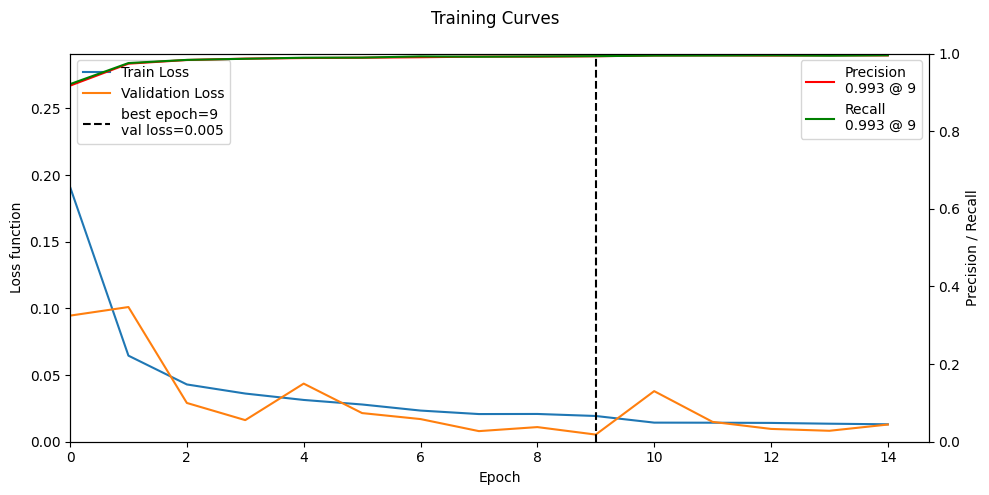

980/980 [==============================] - 402s 410ms/step - loss: 0.0131 - accuracy: 0.9956 - precision: 0.9951 - recall: 0.9954 - val_loss: 0.0129 - val_accuracy: 0.9947 - val_precision: 0.9901 - val_recall: 0.9986 - lr: 0.0011


In [16]:
# Load the ensemble model again
ensemble_model = stacked_model(LEARNING_RATE=best_params['LEARNING_RATE'], DROPOUT_RATE=best_params['DROPOUT_RATE'])

# If you want to skip Optuna, simply comment out the line above and uncomment the line below
# ensemble_model = stacked_model(LEARNING_RATE=0.0001, DROPOUT_RATE=0.2)

history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS, callbacks=[early_stopping, reduce_lr, TrainingCurveCallback()])

### Saving the model

In [17]:
model_filename = 'best_model.keras' # Intentionally declared in separate cell

In [18]:
ensemble_model.save(model_filename)

# Sanity check
print(f"Model successfully saved as {model_filename}") if os.path.exists(model_filename) else print(f"Failed to save the model.")

Model successfully saved as best_model.keras


### Loading the model

In [19]:
optimized_ensemble = tf.keras.models.load_model(model_filename) # Intentionally declared in separate cell

### Testing w/ `val` set

In [20]:
final_val_loss, final_val_accuracy, *rest = optimized_ensemble.evaluate(val_rsc)
print(f"Ensemble Model - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")

196/196 [==============================] - 71s 337ms/step - loss: 0.0054 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9983
Ensemble Model - Validation Loss: 0.0054, Validation Accuracy: 0.9986


### Testing w/ `test` set

In [21]:
# Gather true test labels
y_true = []
for _, labels in test_rsc:
    y_true.extend(labels.numpy())

# Sanity check
assert len(y_true) > 1, "True label list is empty!"

# Predict on test dataset
y_pred = optimized_ensemble.predict(test_rsc)

131/131 [==============================] - 51s 361ms/step


<Figure size 800x800 with 0 Axes>

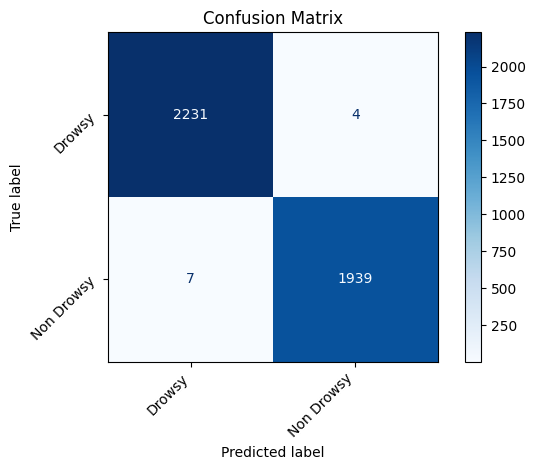

In [22]:
# Need to convert prediction labels to binary for confusion matrix
y_pred_conf = (y_pred >= 0.5).astype(int)

cm = metrics.confusion_matrix(y_true, y_pred_conf)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=45, ha='right') # Rotating labels for better readability
plt.yticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.tight_layout()
# plt.savefig("conf_matrix.png", dpi=300)
plt.show()

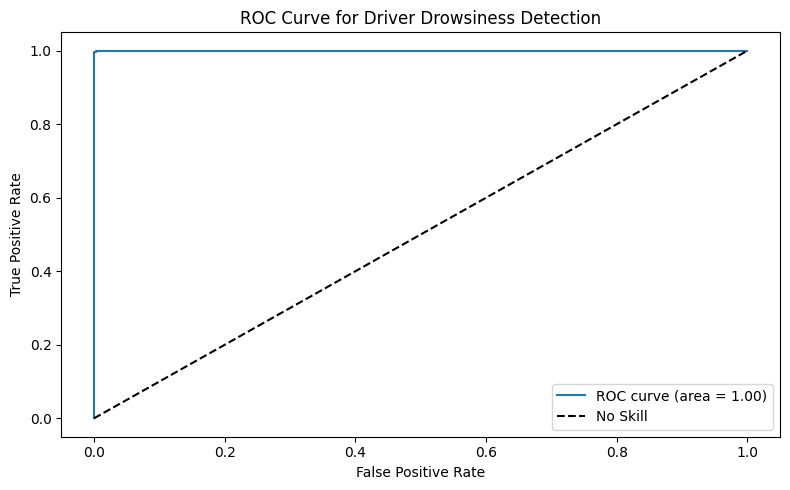

In [23]:
# Predict probabilities on the test set
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Driver Drowsiness Detection')
plt.legend()
plt.tight_layout()
# plt.savefig("roc_curve.png", dpi=300)
plt.show()

1/1 [==============================] - 4s 4s/step


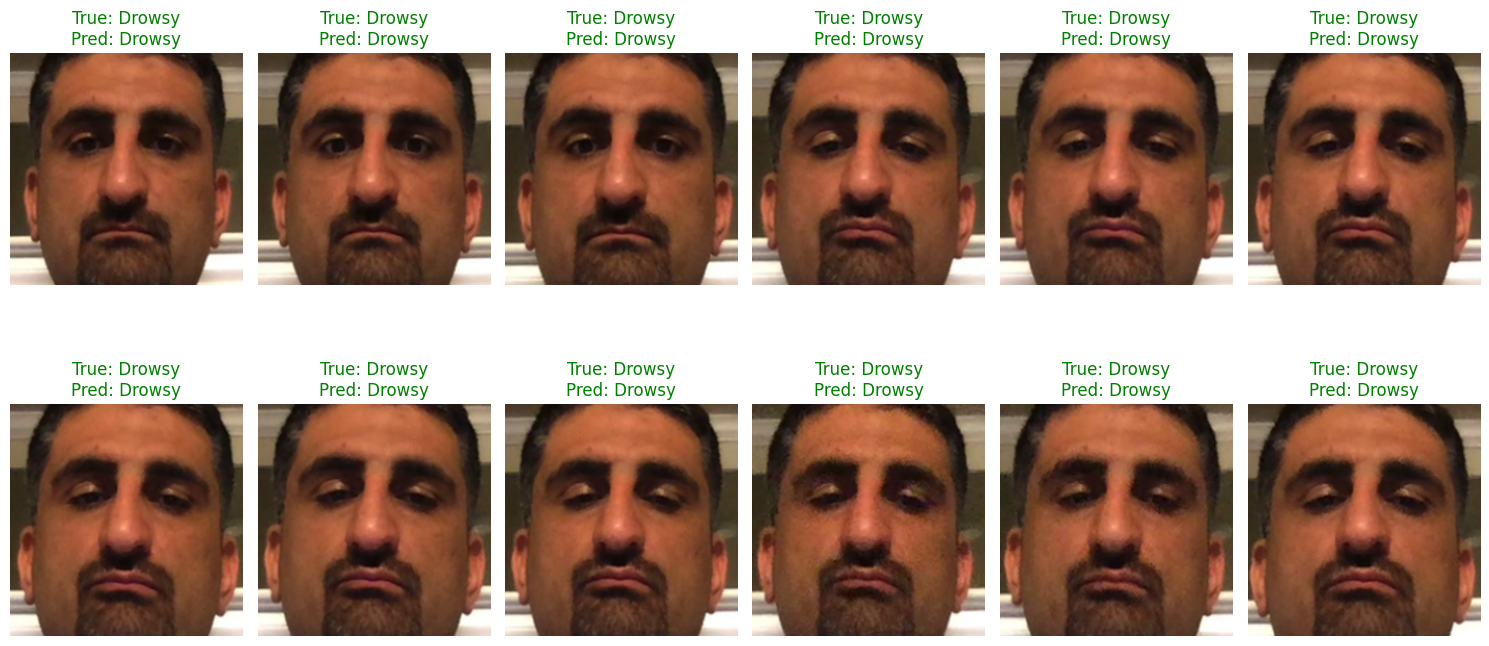

In [24]:
# Viz with test dataset
plt.figure(figsize=(15, 10))
for test_img, test_label in test_rsc.take(1):
    predicted_labels = optimized_ensemble.predict(test_img)
    
    for i in range(12):
        ax = plt.subplot(2, 6, i+1)
        plt.imshow(test_img[i].numpy())
        true_label = class_names[int(test_label[i].numpy())]
        predicted_label = class_names[int(predicted_labels[i])]

        title = f"True: {true_label}\nPred: {predicted_label}"
        plt.title(title, color='green' if true_label == predicted_label else 'red')

        plt.axis('off')
        plt.tight_layout()

### Testing w/ external images

1/1 [==============================] - 0s 47ms/step


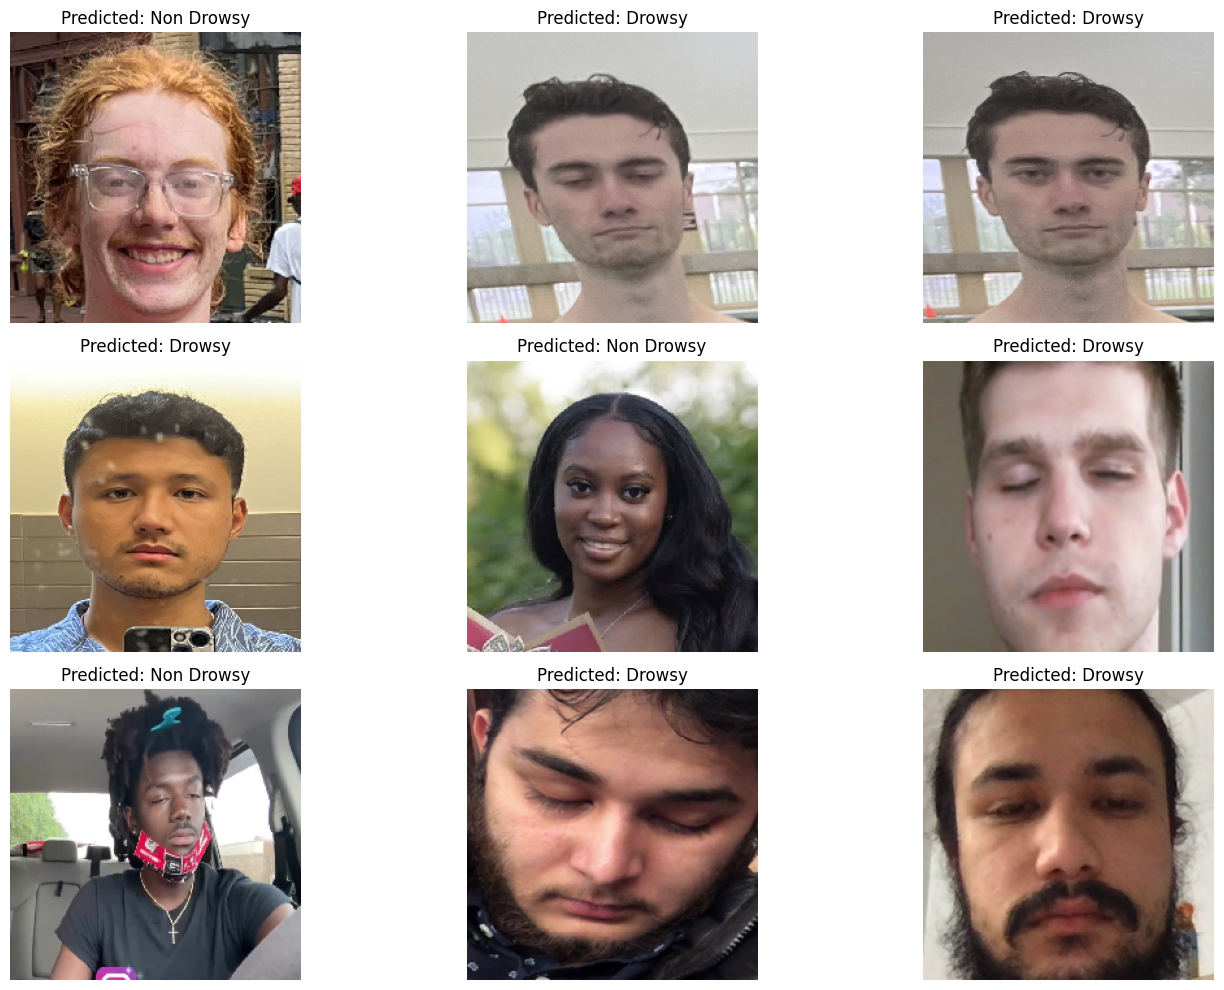

In [25]:
test_dir = 'external'
counter = 1

plt.figure(figsize=(15, 10))
for img_file in os.listdir(test_dir):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_dir, img_file)

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 # model was trained on images in [0-1] scale
        
        pred = (optimized_ensemble.predict(img_array) >= 0.5).astype(int).item()
        
        plt.subplot(3, 3, counter)
        plt.imshow(img)
        plt.title(f"Predicted: {class_names[pred]}")
        plt.axis('off')
        counter += 1
plt.tight_layout()
plt.show()